# My values from fits:

In [2]:
#energies from peak fits:

Cs_Barium_pk = 32.0e3 #in eV
Cs_Barium_err = 0.2
Cs_phpk = 661.9e3
Cs_phpk_err = 0.4e3
#we dont see cesium pair production because the relevant energy is too low-- look into the spike at like 1.4MeV?
Cs_scatteredge = 467e3 #eV
Cs_scatter_err = 10e3

# General formulae

In [3]:
#Doing it myself:
#From Wikipedia
import numpy as np
#consts
Ee = 511e3 #eV
Z = 53 #iodine
#re = 2.8179403227e-15 #m
re = np.sqrt(0.07941) #classical electron radius in barns
alpha = 1/137
#k = Eg/Ee
Cs_k_ph = Cs_phpk/Ee
Cs_k_c = Cs_scatteredge/Ee


#PHOTOELECTRIC
def sigma_ph(Z, alpha, re, k):
    return (16/3) * np.sqrt(2) * np.pi * re**2 * alpha**4 * (Z**5 / k**3.5) * 1e-24 #barns to cm^2


#COMPTON
def calculate_sigma_c(Z, re, k):
    if k <= 0:
        raise ValueError("k must be greater than 0")
    
    term1 = (1 + k) / (k**2)
    bracket1 = (2 * (1 + k) / (1 + 2 * k)) - (np.log(1 + 2 * k) / k)
    
    term2 = np.log(1 + 2 * k) / (2 * k)
    term3 = (1 + 3 * k) / ((1 + 2 * k)**2)
    
    sigma_c = Z * 2 * np.pi * re**2 * (term1 * bracket1 + term2 - term3)
    return sigma_c *1e-24*0.5

#PAIR PRODUCTION
def calculate_rho(k):
    if k <= 0:
        raise ValueError("k must be greater than 0")
    return (2 * k - 4) / (2 + k + 2 * np.sqrt(2 * k))

def calculate_sigma_pair(Z, re, k, alpha):
    if k <= 0:
        raise ValueError("k must be greater than 0")
    
    rho = calculate_rho(k)
    
    term1 = Z**2 * alpha * re**2 * (2 * np.pi / 3)
    term2 = ((k - 2) / k)**3
    
    rho_term = 1 + (0.5 * rho) + (23 / 40) * rho**2 + (11 / 60) * rho**3 + (29 / 960) * rho**4
    
    sigma_pair = term1 * term2 * rho_term 
    return sigma_pair * 1e-24*1.5

#Secondary effects (?) pair production in electron field; only works for k>4
def sigma_trip(Z, alpha, re, k, a, b):
    term1 = (28/9) * np.log(2 * k) - (218/27)
    term2 = (1/k) * (- (4/3) * np.log(2 * k)**3 + 3 * np.log(2 * k)**2 - (60 + 16*a)/3 * np.log(2 * k) + (123 + 12*a + 16*b)/3)
    term3 = (1/k**2) * ((8/3) * np.log(2 * k)**3 - 4 * np.log(2 * k)**2 + (51 + 32*a)/3 * np.log(2 * k) - (123 + 32*a + 64*b)/6)
    term4 = (1/k**3) * (np.log(2 * k)**2 - (53/9) * np.log(2 * k) - (2915 - 288*a)/216)
    term5 = (1/k**4) * (- (49/18) * np.log(2 * k) - 115/432)
    term6 = (1/k**5) * (- (77/36) * np.log(2 * k) - 10831/8640)
    term7 = (1/k**6) * (- (641/300) * np.log(2 * k) - 64573/36000)
    term8 = (1/k**7) * (- (4423/1800) * np.log(2 * k) - 394979/216000)
    
    sigma = Z * alpha * re**2 * (term1 + term2 + term3 + term4 + term5 + term6 + term7 + term8)
    return sigma

#photoelectric
Cs_sigma_photo = sigma_ph(Z_cs, alpha, re, Cs_k_ph)
print(Cs_sigma_photo)
#compton
Cs_sigma_compton = calculate_sigma_c(Z, re, Cs_k_c)
print(Cs_sigma_compton)

sigma_cs_tot = Cs_sigma_photo + Cs_sigma_compton #in cm^2
mu_L = sigma_cs_tot * 3.67 #g/cm^3
print(mu_L)

NameError: name 'Z_cs' is not defined

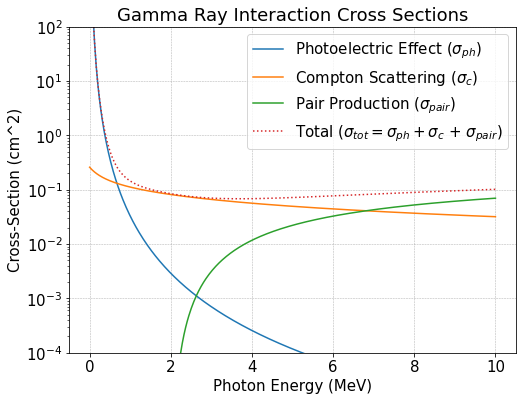

In [41]:
import matplotlib.pyplot as plt

def gamma_cross_section(k, Z):
    """
    Determine the dominant interaction mechanism based on photon energy.
    :param E: Photon energy in MeV
    :param Z: Atomic number of the material
    :return: Tuple of cross-sections (photoelectric, Compton, pair production) in cm^2
    """
    photoelectric = sigma_ph(Z, alpha, re, k)
    compton = calculate_sigma_c(Z,re, k)
    pair_production = calculate_sigma_pair(Z, re, k, alpha)
    return photoelectric, compton, pair_production

plt.rcParams.update({'font.size': 15})
# Define energy range for k from 0 to 10 MeV
k_values = np.linspace(0.001, 10, 500)  # Energy in MeV
Z = 53  # Example atomic number (Iodine)
N_A = 6.022e23
m_A = 149.984 #g/mol
rho_A = 3.67 #g/cm^3

photoelectric_values = []
compton_values = []
pair_production_values = []
sigma_tot = []
for k in k_values:
    photo, compton, pair = gamma_cross_section(k, Z)
    photoelectric_values.append((photo*N_A*rho_A)/m_A)
    compton_values.append((compton*N_A*rho_A)/m_A)
    pair_production_values.append((pair*N_A*rho_A)/m_A)
    if pair > 0: 
        tot = (photo*N_A*rho_A)/m_A+(compton*N_A*rho_A)/m_A+(pair*N_A*rho_A)/m_A
    else: 
        tot = (photo*N_A*rho_A)/m_A+(compton*N_A*rho_A)/m_A
    sigma_tot.append(tot)
# Plot results
plt.figure(figsize=(8, 6))
plt.plot(k_values, photoelectric_values, label="Photoelectric Effect ($\sigma_{ph}$)")
plt.plot(k_values, compton_values, label="Compton Scattering ($\sigma_{c}$)")
plt.plot(k_values, pair_production_values, label="Pair Production ($\sigma_{pair}$)")
plt.plot(k_values, sigma_tot, linestyle = ':', label="Total ($\sigma_{tot} = \sigma_{ph} + \sigma_{c}$ + $\sigma_{pair}$)")
plt.xlabel("Photon Energy (MeV)")
plt.ylabel("Cross-Section (cm^2)")
plt.yscale("log")  # Set y-axis to logarithmic scale
plt.ylim(1e-4,1e2)
# plt.xlim(0,4)
plt.title("Gamma Ray Interaction Cross Sections")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.savefig(r"C:\Users\sarah\Downloads\gamma_cros_sections.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()


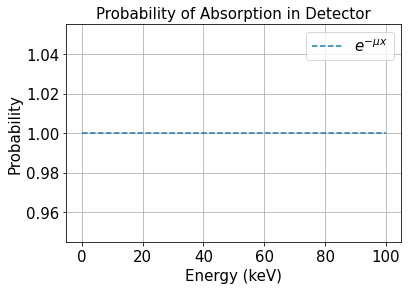

In [25]:
mu_L = []
for i in sigma_tot: 
    mu_L.append(N_A*i)
    
# Define x values from 0 to 100
x_values = np.linspace(0, 100, num=101)

# Define mu (change this later)
mu = mu_L  # Example value

# Compute y values
y_values = []
for i in range(101):
    y_values.append(np.exp(-(1/mu_L[i]) * x_values[i]))

# Create plot with dashed line
plt.plot(x_values, y_values, "--", label=r'$e^{-\mu x}$')

# Set labels and title with font size 15
plt.xlabel("Energy (keV)", fontsize=15)
plt.ylabel("Probability", fontsize=15)
plt.title("Probability of Absorption in Detector", fontsize=15)

# Other plot settings
plt.legend(fontsize=15)
plt.grid()
plt.show()

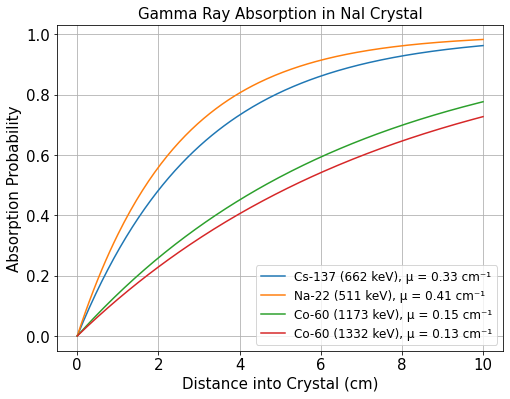

In [29]:
import numpy as np
import matplotlib.pyplot as plt

# Define x values (distance traveled into the NaI crystal in cm)
x_values = np.linspace(0, 10, num=200)  # From 0 to 10 cm

# Define mu values for each gamma-ray energy (in cm^-1)
mu_values = {
    "Cs-137 (662 keV)": 0.33,
    "Na-22 (511 keV)": 0.41,
    "Co-60 (1173 keV)": 0.15,
    "Co-60 (1332 keV)": 0.13
}

# Plot each isotope's absorption probability
plt.figure(figsize=(8, 6))

for label, mu in mu_values.items():
    P_abs = 1 - np.exp(-mu * x_values)  # Absorption probability
    plt.plot(x_values, P_abs, label=f"{label}, μ = {mu:.2f} cm⁻¹")

# Set labels and title
plt.xlabel("Distance into Crystal (cm)", fontsize=15)
plt.ylabel("Absorption Probability", fontsize=15)
plt.title("Gamma Ray Absorption in NaI Crystal", fontsize=15)

# Legend and grid
plt.legend(fontsize=12)
plt.grid()
plt.savefig(r"C:\Users\sarah\Downloads\gamma_probabilities.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
# Show plot
plt.show()

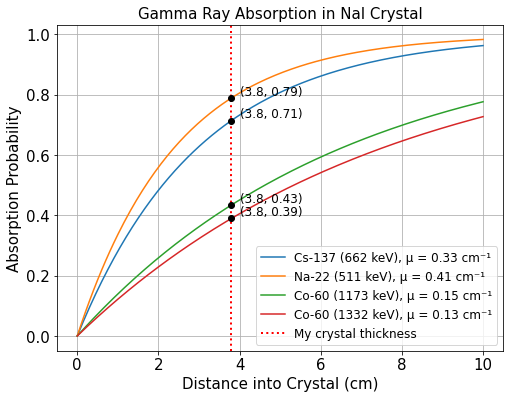

In [31]:
import numpy as np
import matplotlib.pyplot as plt

# Define x values (distance traveled into the NaI crystal in cm)
x_values = np.linspace(0, 10, num=200)  # From 0 to 10 cm
crystal_thickness = 3.8  # The vertical line position

# Define mu values for each gamma-ray energy (in cm^-1)
mu_values = {
    "Cs-137 (662 keV)": 0.33,
    "Na-22 (511 keV)": 0.41,
    "Co-60 (1173 keV)": 0.15,
    "Co-60 (1332 keV)": 0.13
}

# Create figure
plt.figure(figsize=(8, 6))

# Plot each isotope's absorption probability
for label, mu in mu_values.items():
    P_abs = 1 - np.exp(-mu * x_values)  # Absorption probability
    plt.plot(x_values, P_abs, label=f"{label}, μ = {mu:.2f} cm⁻¹")

    # Find the intersection point (P_abs at x = 3.8 cm)
    y_intersection = 1 - np.exp(-mu * crystal_thickness)
    
    # Plot intersection point
    plt.scatter(crystal_thickness, y_intersection, color="black", zorder=3)
    
    # Annotate intersection point
    plt.text(crystal_thickness + 0.2, y_intersection, 
             f"({crystal_thickness:.1f}, {y_intersection:.2f})", 
             fontsize=12, verticalalignment="bottom")

# Add vertical line for crystal thickness
plt.axvline(x=crystal_thickness, color="red", linestyle=":", linewidth=2, label="My crystal thickness")

# Set labels and title
plt.xlabel("Distance into Crystal (cm)", fontsize=15)
plt.ylabel("Absorption Probability", fontsize=15)
plt.title("Gamma Ray Absorption in NaI Crystal", fontsize=15)

# Legend and grid
plt.legend(fontsize=12)
plt.grid()

# Show plot
plt.show()

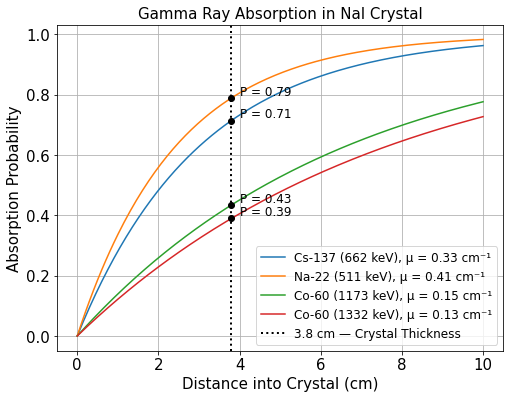

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Define x values (distance traveled into the NaI crystal in cm)
x_values = np.linspace(0, 10, num=200)  # From 0 to 10 cm
crystal_thickness = 3.8  # The vertical line position

# Define mu values for each gamma-ray energy (in cm^-1)
mu_values = {
    "Cs-137 (662 keV)": 0.33,
    "Na-22 (511 keV)": 0.41,
    "Co-60 (1173 keV)": 0.15,
    "Co-60 (1332 keV)": 0.13
}

# Create figure
plt.figure(figsize=(8, 6))

# Plot each isotope's absorption probability
for label, mu in mu_values.items():
    P_abs = 1 - np.exp(-mu * x_values)  # Absorption probability
    plt.plot(x_values, P_abs, label=f"{label}, μ = {mu:.2f} cm⁻¹")

    # Find the intersection point (P_abs at x = 3.8 cm)
    y_intersection = 1 - np.exp(-mu * crystal_thickness)
    
    # Plot intersection point
    plt.scatter(crystal_thickness, y_intersection, color="black", zorder=3)
    
    # Annotate intersection point with "P = [y-value]"
    plt.text(crystal_thickness + 0.2, y_intersection, 
             f"P = {y_intersection:.2f}", 
             fontsize=12, verticalalignment="bottom")

# Add vertical line for crystal thickness with new label
plt.axvline(x=crystal_thickness, color="black", linestyle=":", linewidth=2, label = "3.8 cm — Crystal Thickness")

# Set labels and title
plt.xlabel("Distance into Crystal (cm)", fontsize=15)
plt.ylabel("Absorption Probability", fontsize=15)
plt.title("Gamma Ray Absorption in NaI Crystal", fontsize=15)

# Legend and grid
plt.legend(fontsize=12)
plt.grid()
plt.savefig(r"C:\Users\sarah\Downloads\gamma_probabilities.png", dpi=300, bbox_inches="tight", pad_inches=0.1)
# Show plot
plt.show()

Photoelectric cross section: 1.88e+01 cm²
Compton scattering cross section: 7.75e+01 cm²
Pair production cross section: 0.00e+00 cm²


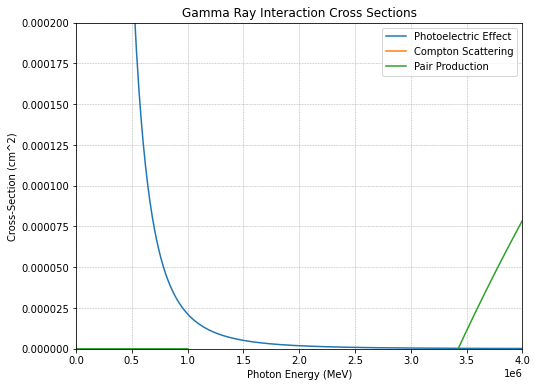

In [67]:
#general formulae 
#ChatGPT's attempt
import numpy as np

# Constants
alpha = 1 / 137  # Fine-structure constant
re = 2.8179403227e-15  # Classical electron radius in meters
me_c2 = 511e3  # Electron rest mass energy in eV
phi_0 = 0.66526e-24  # Thomson cross section in cm²

def photoelectric_cross_section(Z, E_gamma):
    """
    Calculate the photoelectric effect cross section.
    
    Parameters:
        Z (int): Atomic number of the absorber's element.
        E_gamma (float): Photon energy in eV.
    
    Returns:
        float: Photoelectric cross section in cm².
    """
    k = E_gamma / me_c2
    sigma_ph = (16 / 3) * np.sqrt(2) * np.pi * re**2 * alpha**4 * (Z**5) / (k**3.5)
    return sigma_ph * 1e24  # Convert from m² to cm²

def compton_cross_section(Z, E_gamma):
    """
    Calculate the Compton scattering cross section.
    
    Parameters:
        Z (int): Atomic number of the absorber's element.
        E_gamma (float): Photon energy in eV.
    
    Returns:
        float: Compton scattering cross section in cm².
    """
    k = E_gamma / me_c2
    term1 = (1 + k) / (k**2)
    term2 = (2 * (1 + k)) / (1 + 2 * k)
    term3 = np.log(1 + 2 * k) / k
    term4 = (1 + 3 * k) / ((1 + 2 * k)**2)
    sigma_C = phi_0 * Z * (term1 * (term2 - term3) + term4)
    return sigma_C * 1e24  # Convert from m² to cm²

def pair_production_cross_section(Z, E_gamma):
    """
    Calculate the pair production cross section.
    
    Parameters:
        Z (int): Atomic number of the absorber's element.
        E_gamma (float): Photon energy in eV.
    
    Returns:
        float: Pair production cross section in cm².
    """
    if E_gamma < 2 * me_c2:
        return 0  # Pair production threshold
    k = E_gamma / me_c2
    term1 = 28 / 9 * np.log(2 * k)
    term2 = -218 / 27
    sigma_pair = alpha * re**2 * Z**2 * (term1 + term2)
    return sigma_pair * 1e24  # Convert from m² to cm²

# Example usage
Z = 53  # Iodine
E_gamma = 662e3  # 1 MeV in eV

sigma_ph = photoelectric_cross_section(Z, 2e4)
sigma_C = compton_cross_section(Z, 2e4)
sigma_pair = pair_production_cross_section(Z, 2e4)

print(f"Photoelectric cross section: {sigma_ph:.2e} cm²")
print(f"Compton scattering cross section: {sigma_C:.2e} cm²")
print(f"Pair production cross section: {sigma_pair:.2e} cm²")


import matplotlib.pyplot as plt

def gamma_cross_section(k, Z):
    """
    Determine the dominant interaction mechanism based on photon energy.
    :param E: Photon energy in MeV
    :param Z: Atomic number of the material
    :return: Tuple of cross-sections (photoelectric, Compton, pair production) in cm^2
    """
    photoelectric = photoelectric_cross_section(Z, k)
    compton = compton_cross_section(Z, k)
    pair_production = pair_production_cross_section(Z, k)
    return photoelectric, compton, pair_production

# Define energy range for k from 0 to 10 MeV
k_values = np.linspace(1000, 10000000, 500)  # Energy in MeV
Z = 53  # Example atomic number (Iodine)

photoelectric_values = []
compton_values = []
pair_production_values = []

for k in k_values:
    photo, compton, pair = gamma_cross_section(k, Z)
    photoelectric_values.append(photo)
    compton_values.append(compton)
    pair_production_values.append(pair)

# Plot results
plt.figure(figsize=(8, 6))
plt.plot(k_values, photoelectric_values, label="Photoelectric Effect")
plt.plot(k_values, compton_values, label="Compton Scattering")
plt.plot(k_values, pair_production_values, label="Pair Production")
plt.xlabel("Photon Energy (MeV)")
plt.ylabel("Cross-Section (cm^2)")
#plt.yscale("log")  # Set y-axis to logarithmic scale
plt.ylim(0,.00020)
plt.xlim(0,4000000)
plt.title("Gamma Ray Interaction Cross Sections")
plt.legend()
plt.grid(True, linestyle="--", linewidth=0.5)
plt.show()



In [7]:
photoelectric_cross_section(137, 662.2e3)

0.010405400045167571

In [6]:
def cm2_to_barns(value_cm2):
    """
    Convert cross-section from cm^2 to barns.
    :param value_cm2: Cross-section in cm^2
    :return: Cross-section in barns
    """
    return value_cm2 * 1e24  # 1 cm^2 = 10^24 barns

cm2_to_barns(0.010405400045167571)

1.040540004516757e+22